In [1]:

%load_ext autoreload
%autoreload 2
import networkx as nx
import matplotlib.pyplot as plt
import random
#from pcc_implementacao import *
import pandas as pd
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
import numpy as np

from model import *
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Particle competition for complex network community detection
### Summary of the Process  
1. Initialization: Start with several particles placed randomly in the network, each with low potential.  
2. Iteration: In each step, particles choose a neighboring node to visit based in a mix of random and deterministic rules.  
3. Update Ownership: Depending on the visit outcome, update the ownership and potential of both the particle and the node.  
4. Convergence: Repeat the process until each community is owned by a single particle, indicating successful community detection.  


# Dataset

In [2]:
df_sar = pd.read_csv('data/sar_dataset.csv')
df_sar

feature_1  feature_2 true_label  observed_label
0    1.496714   0.861736   positive               0
1    1.647689   2.523030   positive               0
2    0.765847   0.765863   positive               1
3    2.579213   1.767435   positive               0
4    0.530526   1.542560   positive               1
5    0.536582   0.534270   positive               0
6    1.241962  -0.913280   positive               1
7   -0.724918   0.437712   positive               0
8   -0.012831   1.314247   positive               0
9    0.091976  -0.412304   positive               0
10   2.465649   0.774224   positive               0
11   1.067528  -0.424748   positive               0
12   0.455617   1.110923   positive               0
13  -0.150994   1.375698   positive               0
14   0.399361   0.708306   positive               0
15   0.398293   2.852278   positive               0
16   0.986503  -0.057711   positive               1
17   1.822545  -0.220844   positive               0
18   1.208864  -0.959670   positive               1
19  -0.328186   1.196861   positive               0
20  -0.261533  -0.828632   negative               0
21  -1.115648  -1.301104   negative               0
22  -2.478522  -1.719844   negative               0
23  -1.460639   0.057122   negative               0
24  -0.656382  -2.763040   negative               0
25  -0.675916  -1.385082   negative               0
26  -1.676922  -0.388324   negative               0
27   0.031000  -0.068720   negative               0
28  -1.839218  -1.309212   negative               0
29  -0.668737  -0.024455   negative               0
30  -1.479174  -1.185659   negative               0
31  -2.106335  -2.196207   negative               0
32  -0.187474   0.356240   negative               0
33  -1.072010   0.003533   negative               0
34  -0.638364  -1.645120   negative               0
35  -0.638604   0.538037   negative               0
36  -1.035826   0.564644   negative               0
37  -3.619745  -0.178097   negative               0
38  -0.912953  -1.299007   negative               0
39  -0.908239  -2.987569   negative               0

In [3]:
px.scatter(df_sar, x = 'feature_1', y = 'feature_2', color = 'true_label')

# Graph Creation

In [4]:
# Choose the number of neighbors (k)
k = 3

Graph created with k=3
Number of nodes: 40
Number of edges: 81


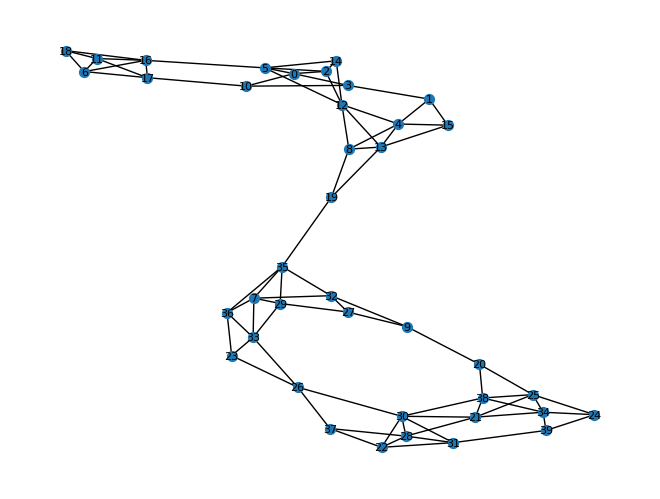

In [5]:
# --- 1. Define Nodes ---
# Nodes will correspond to the index of the dataframe rows
nodes = df_sar.index

# --- 2. Calculate Neighbors ---
# Select the features to calculate distance
features = df_sar[['feature_1', 'feature_2']].values


# We ask for k+1 neighbors because the point itself is always the closest (distance 0)
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(features)
distances, indices = nbrs.kneighbors(features)

# --- 3. Define Edges ---
# Create an edge list based on k-NN
# indices[i, 0] is always node i itself, so we start from indices[i, 1]
edge_list = []
for i in range(len(features)):
    for j_idx in range(1, k + 1): # Iterate through the k nearest neighbors (excluding self)
        neighbor_index = indices[i, j_idx]
        # Add edge (i, neighbor_index) - ensure order doesn't matter for undirected graph
        # We can add edges in both directions initially and NetworkX handles duplicates
        edge_list.append(tuple(sorted((i, neighbor_index))))


# Remove duplicate edges by converting to a set
unique_edges = set(edge_list)

# --- 4. Build Graph ---
# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(nodes)

# Add edges
G.add_edges_from(unique_edges)

# Optional: Add features/labels as node attributes
# Convert labels to string type if they aren't already, for compatibility
attributes = df_sar.to_dict('index') # Get attributes for each node (row index)
nx.set_node_attributes(G, attributes)
print(f"Graph created with k={k}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.savefig("graph_dataset.png", dpi=600)

In [6]:
G.nodes(data=True)[0]

{'feature_1': 1.496714153011233,
 'feature_2': 0.8617356988288154,
 'true_label': 'positive',
 'observed_label': 0}

# Execução

Iter 0: Potential Low? True, Potential Avg: 0.05, No Positive Cluster? True, Unowned Nodes? True
Iter 1: Potential Low? True, Potential Avg: 0.05, No Positive Cluster? True, Unowned Nodes? True
Iter 2: Potential Low? True, Potential Avg: 0.0515125, No Positive Cluster? True, Unowned Nodes? True
Iter 3: Potential Low? True, Potential Avg: 0.06065, No Positive Cluster? True, Unowned Nodes? True
Iter 4: Potential Low? True, Potential Avg: 0.07930000000000001, No Positive Cluster? True, Unowned Nodes? True
Iter 5: Potential Low? True, Potential Avg: 0.08624625, No Positive Cluster? True, Unowned Nodes? True
Iter 6: Potential Low? True, Potential Avg: 0.10363275000000001, No Positive Cluster? True, Unowned Nodes? True
Iter 7: Potential Low? True, Potential Avg: 0.11632935000000003, No Positive Cluster? True, Unowned Nodes? True
Iter 8: Potential Low? True, Potential Avg: 0.13909488875000003, No Positive Cluster? True, Unowned Nodes? True
Iter 9: Potential Low? True, Potential Avg: 0.1747675

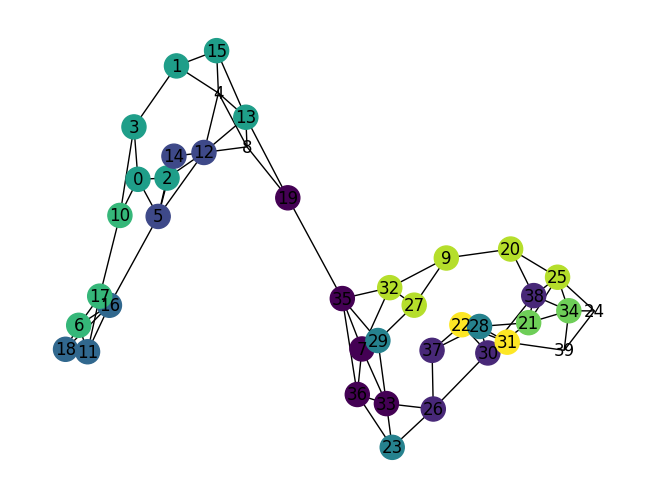

In [10]:
p_det = 0.4
M = 10 # number of particles
delta_p = 0.1
delta_v = 0.1


PCM = ParticleCompetitionModel(G, M,  p_det, delta_p, delta_v)
g_sim = PCM.run_simulation(50000)
PCM.visualize_communities(g_sim)

In [10]:
PCM.graph_without_owners()

False

In [11]:
PCM.check_average_node_potential()[1]

np.False_

In [12]:
PCM.check_positive_cluster_existence()

True

MCLS

In [15]:
mcls = MCLS(g_sim)
mcls.assign_cluster_label()
mcls.calculate_dissimilarity()
mcls.rank_nodes_dissimilarity(20)

[(39, 12),
 (21, 11),
 (22, 11),
 (24, 11),
 (28, 11),
 (31, 11),
 (34, 11),
 (25, 10),
 (30, 10),
 (37, 10),
 (38, 10),
 (20, 9),
 (26, 9),
 (9, 8),
 (23, 8),
 (27, 8),
 (33, 8),
 (7, 7),
 (29, 7),
 (32, 7)]

# Planetoid

In [2]:
def load_cora_for_pcm(positive_class_label: int = 3):
    """
    Loads the Cora dataset, converts it to a NetworkX graph, and sets it up
    for PU learning by assigning one class as Positive (1) and the rest
    as Unlabeled (0).

    Args:
        positive_class_label (int): The original label from Cora to be treated as the Positive class.

    Returns:
        nx.Graph: A NetworkX graph ready for the ParticleCompetitionModel.
    """
    # 1. Load the dataset
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]
    print(f"Loaded Cora dataset: {data}")

    # 2. Convert the PyG Data object to a NetworkX graph
    # Your model uses an undirected graph, so to_undirected=True is important.
    G = to_networkx(data, to_undirected=True)
    print(f"Converted to NetworkX. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # 3. Set up node attributes for PU Learning
    for i in range(data.num_nodes):
        node_label = data.y[i].item() # The original class label (0-6)

        # 'true_label' is for evaluation later. 1 if it's the positive class, 0 otherwise.
        G.nodes[i]['true_label'] = 1 if node_label == positive_class_label else 0
        
        # 'observed_label' is what the algorithm sees.
        # Mark the chosen positive class as 1 (P) and all others as 0 (U).
        G.nodes[i]['observed_label'] = 1 if node_label == positive_class_label else 0

    print(f"Set up PU labels with class {positive_class_label} as Positive.")
    
    # We don't need to add 'feature_1' or 'feature_2' as your PCM algorithm
    # doesn't use them, but this shows where the original features are.
    # The 'data.x' tensor holds these features if you need them later.
    # nx.set_node_attributes(G, data.x.numpy(), 'features')

    return G


In [3]:
G_cora= load_cora_for_pcm(3)

Loaded Cora dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Converted to NetworkX. Nodes: 2708, Edges: 5278
Set up PU labels with class 3 as Positive.


In [5]:
p_det = 0.6
M = 387
delta_p = 0.2
delta_v = 0.1
max_sim_iterations = 20000 


PCM = ParticleCompetitionModel(G_cora, M, p_det, delta_p, delta_v, cluster_strategy='percentage', positive_cluster_threshold=0.1)
g_sim, history = PCM.run_simulation(max_sim_iterations)

Iter 0: Potential Low? True, Potential Avg: 0.04999999999999999, No Positive Cluster? True, Unowned Nodes? True
Iter 1: Potential Low? True, Potential Avg: 0.06417513151516308, No Positive Cluster? True, Unowned Nodes? True
Iter 2: Potential Low? True, Potential Avg: 0.09892762264475925, No Positive Cluster? False, Unowned Nodes? True
Iter 3: Potential Low? True, Potential Avg: 0.13323686026067383, No Positive Cluster? False, Unowned Nodes? True
Iter 4: Potential Low? True, Potential Avg: 0.1625801588268799, No Positive Cluster? False, Unowned Nodes? True
Iter 5: Potential Low? True, Potential Avg: 0.19005571658522624, No Positive Cluster? False, Unowned Nodes? True
Iter 6: Potential Low? True, Potential Avg: 0.21596797206392937, No Positive Cluster? False, Unowned Nodes? True
Iter 7: Potential Low? True, Potential Avg: 0.23577285391118674, No Positive Cluster? False, Unowned Nodes? True
Iter 8: Potential Low? True, Potential Avg: 0.2511029838997215, No Positive Cluster? False, Unowned



the file model.py is the current state of my code, i ran the simulation as follows:
p_det = 0.6
M = 387
delta_p = 0.2
delta_v = 0.1
max_sim_iterations = 20000 


PCM = ParticleCompetitionModel(G_cora, M, p_det, delta_p, delta_v, cluster_strategy='percentage', positive_cluster_threshold=0.1)
g_sim = PCM.run_simulation(max_sim_iterations)
this is the last lines 
Iter 19997: Potential Low? True, Potential Avg: 0.5138468028537786, No Positive Cluster? False, Unowned Nodes? True
Iter 19998: Potential Low? True, Potential Avg: 0.5151258616002204, No Positive Cluster? False, Unowned Nodes? True
Iter 19999: Potential Low? True, Potential Avg: 0.516090224195535, No Positive Cluster? False, Unowned Nodes? True
Iter 20000: Potential Low? True, Potential Avg: 0.5171638383787109, No Positive Cluster? False, Unowned Nodes? True
and the following is the output for 
print(g_sim.nodes(data=True))

In [53]:
print(g_sim.nodes(data=True))

[(0, {'true_label': 1, 'observed_label': 1, 'owner': None, 'potential': 0.05}), (1, {'true_label': 0, 'observed_label': 0, 'owner': 232, 'potential': 0.9999999999999998}), (2, {'true_label': 0, 'observed_label': 0, 'owner': 361, 'potential': 0.5306347793180902}), (3, {'true_label': 0, 'observed_label': 0, 'owner': None, 'potential': 0.05}), (4, {'true_label': 1, 'observed_label': 1, 'owner': 199, 'potential': 0.8228599549032661}), (5, {'true_label': 0, 'observed_label': 0, 'owner': None, 'potential': 0.05}), (6, {'true_label': 0, 'observed_label': 0, 'owner': 110, 'potential': 0.9616085882060469}), (7, {'true_label': 1, 'observed_label': 1, 'owner': None, 'potential': 0.05}), (8, {'true_label': 1, 'observed_label': 1, 'owner': 150, 'potential': 0.6167060982857123}), (9, {'true_label': 0, 'observed_label': 0, 'owner': 134, 'potential': 0.9999999999999998}), (10, {'true_label': 0, 'observed_label': 0, 'owner': 10, 'potential': 0.9999999999999998}), (11, {'true_label': 0, 'observed_label'